In [1]:
import sys
sys.path.append("/home/amigos/seigyo/analy/shiotani/git/analy_n2data/")
import necstdb
import math
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import n2analy
import xarray as xr
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit

In [2]:
path = '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter'

In [3]:
data = n2analy.get_data(path,'03')

  0%|          | 0/3 [00:00<?, ?it/s]

read end


100%|██████████| 3/3 [00:00<00:00, 13.98it/s]

31.0 OFF 0.0 0.0
31.0 ON 0.0 0.0


In [4]:
xFFTS_Data_topics = [
    
    'xffts_board01',
    'xffts_board02',
    'xffts_board03',
    'xffts_board04',
    'xffts_board05',
    'xffts_board06',
    'xffts_board07',
    'xffts_board08',
    'xffts_board09',
    'xffts_board10',
    'xffts_board11',
    'xffts_board12',
    'xffts_board13',
    'xffts_board14',
    'xffts_board15',
    'xffts_board16'
    
]

In [5]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('xffts_board01').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

In [6]:
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

In [7]:
ON_OL = raw_array['obsmode'] == b'ON        '

In [8]:
ON = raw_array[ON_OL]

In [9]:
ON

<xarray.DataArray (t: 5103, spectral_data: 32768)>
array([[1.3110075e+10, 1.3110075e+10, 1.3110075e+10, ..., 2.1356916e+12,
        2.1310970e+12, 2.1559366e+12],
       [1.2960341e+10, 1.2960341e+10, 1.2960341e+10, ..., 2.1460900e+12,
        2.1293896e+12, 2.1275464e+12],
       [1.3024867e+10, 1.3024867e+10, 1.3024867e+10, ..., 2.1608112e+12,
        2.0973845e+12, 2.1640270e+12],
       ...,
       [1.2988529e+10, 1.2988529e+10, 1.2988529e+10, ..., 2.1348496e+12,
        2.1780415e+12, 2.1889994e+12],
       [1.2891125e+10, 1.2891125e+10, 1.2891125e+10, ..., 2.1442795e+12,
        2.1651486e+12, 2.1469110e+12],
       [1.3118890e+10, 1.3118890e+10, 1.3118890e+10, ..., 2.1449426e+12,
        2.1171588e+12, 2.1660594e+12]], dtype=float32)
Coordinates:
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    obsmode   (t) |S12 b'ON        ' b'ON        ' ... b'ON        '
    scan_num  (t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 30.0 30.0 30.0 30.0 30.0
    azlist    (t) float64 -98.51 -98.51 -98.51 -98.51 ... -100.7 -100.7 -100.7
    ellist    (t) float64 47.14 47.14 47.14 47.14 ... 38.72 38.72 38.72 38.72
Dimensions without coordinates: spectral_data

In [10]:
ON_TP = np.sum(ON,axis=1)

In [11]:
ON_TP

<xarray.DataArray (t: 5103)>
array([4.0068609e+17, 3.9948872e+17, 4.0163617e+17, ..., 3.9773393e+17,
       3.9480147e+17, 3.9412987e+17], dtype=float32)
Coordinates:
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    obsmode   (t) |S12 b'ON        ' b'ON        ' ... b'ON        '
    scan_num  (t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 30.0 30.0 30.0 30.0 30.0
    azlist    (t) float64 -98.51 -98.51 -98.51 -98.51 ... -100.7 -100.7 -100.7
    ellist    (t) float64 47.14 47.14 47.14 47.14 ... 38.72 38.72 38.72 38.72

In [12]:
ON_TP_list = []
for i in range(31):
    ON_tpi = ON_TP['scan_num'] == i
    ON_TPi = ON_TP[ON_tpi]
    ON_TP_list.append(ON_TPi)

In [13]:
az_list = []
for i in range(len(ON_TP_list)):
    az = ON_TP_list[i]['azlist']
    az_list.append(az)

/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


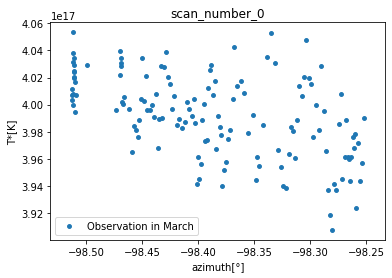

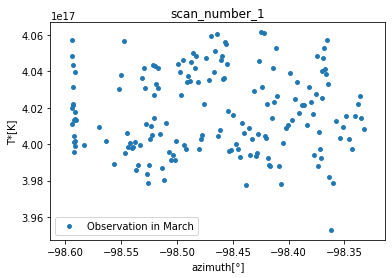

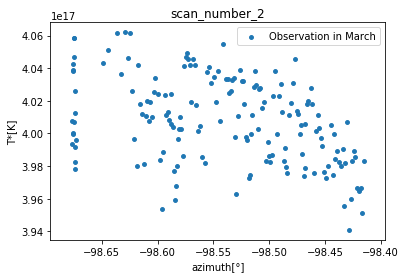

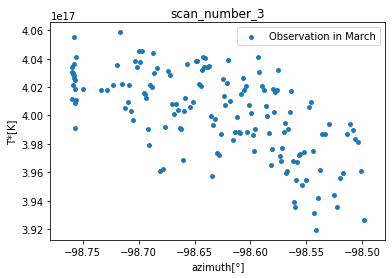

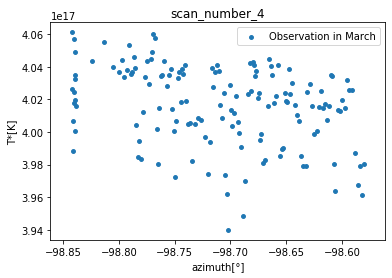

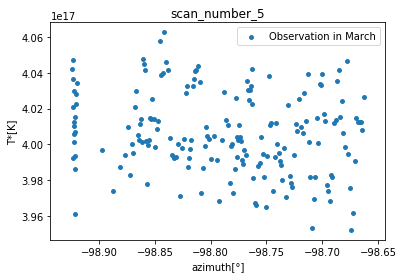

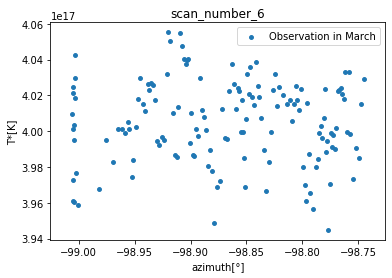

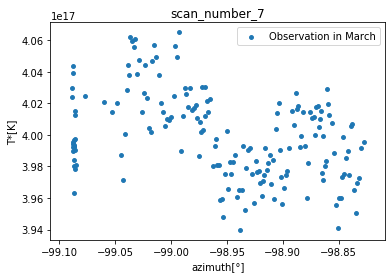

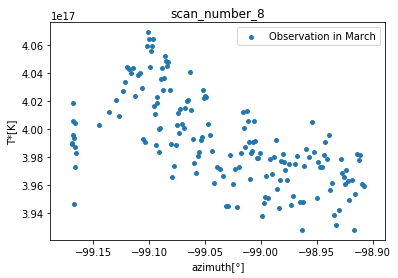

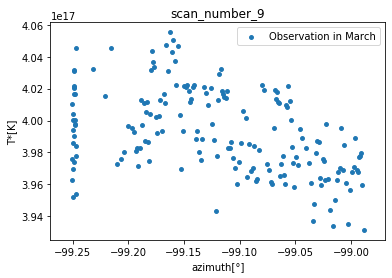

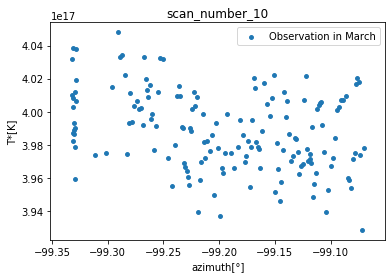

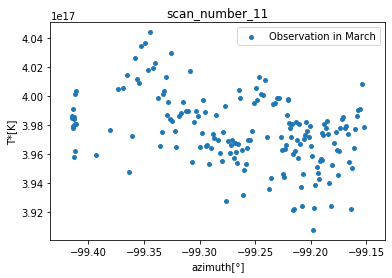

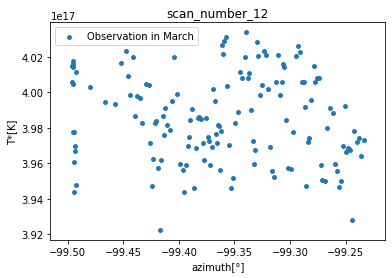

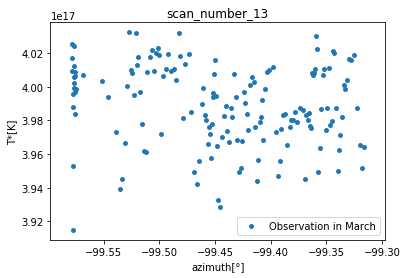

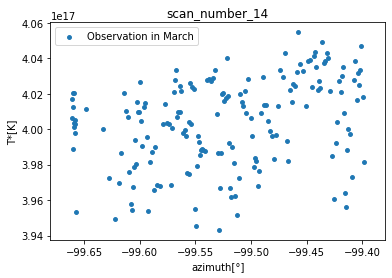

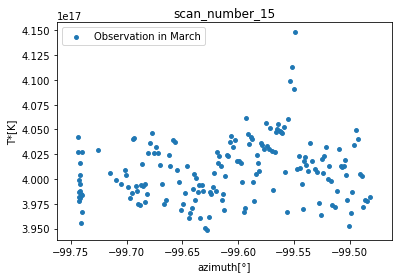

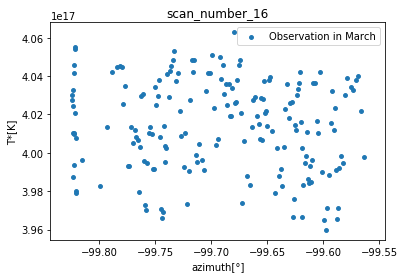

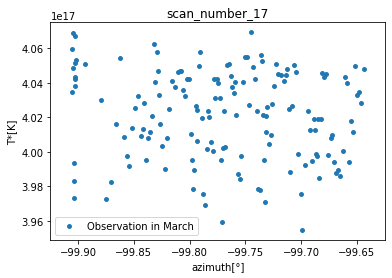

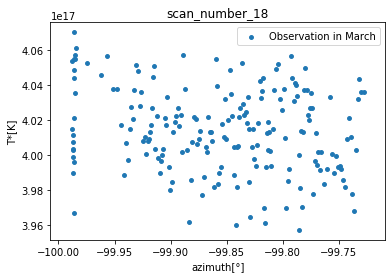

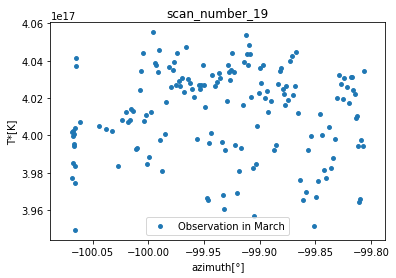

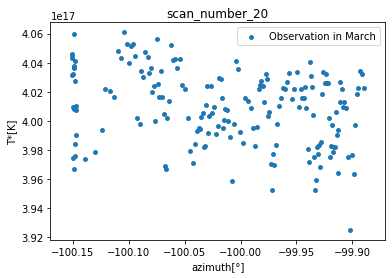

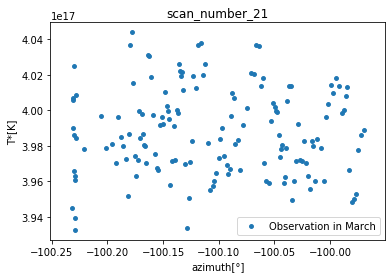

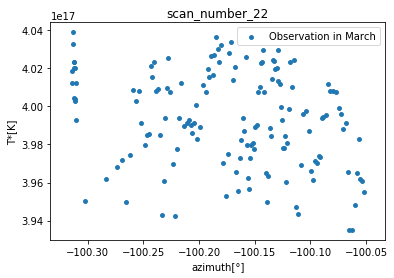

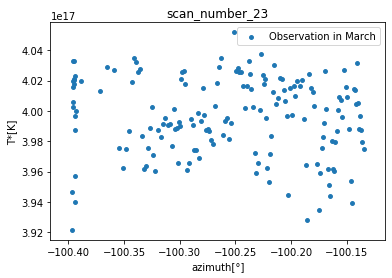

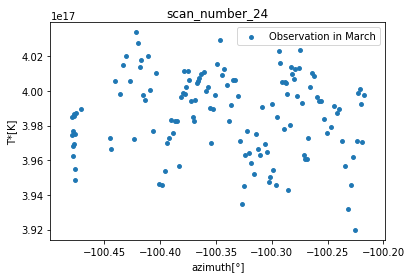

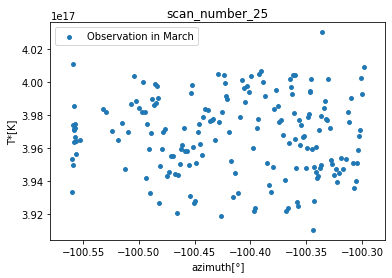

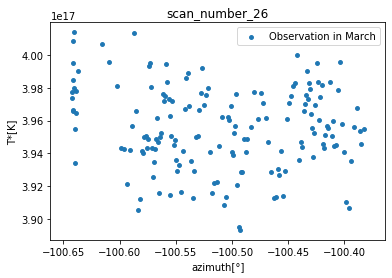

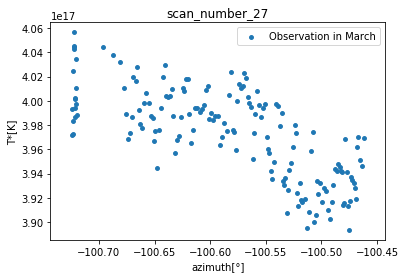

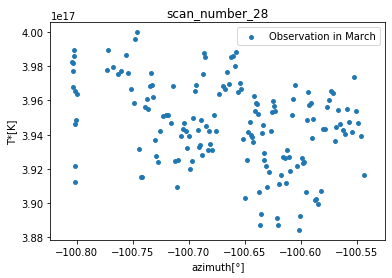

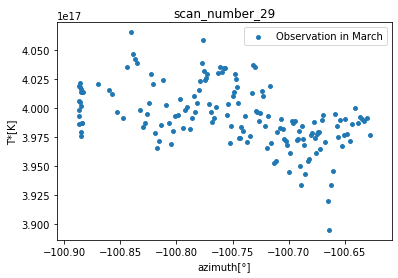

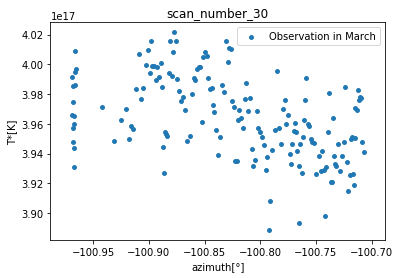

In [14]:
for i in range(len(az_list)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(az_list[i],ON_TP_list[i], s=15, label='Observation in March')
    ax.set_title('scan_number_' + f'{i}')
    ax.set_xlabel('azimuth[°]')
    ax.set_ylabel('T*[K]')
    ax.legend()
    #fig.savefig(f'/home/amigos/seigyo/analy/notebook_2020/Nishioka/per_az/az_T*_scan_nimber{i}.pdf')